In [1]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import AttUNet, UNet, UNetWithPretrainedEncoder
from dataloader import ImageDataset, TransformWrapper

data_pth = Path('/Users/tsakalis/ntua/cellforge/data/inner_embryo_data')
blastocyst_pth = Path('/Users/tsakalis/ntua/cellforge/data/annotation_pn')

blastocyst_images_pth = blastocyst_pth / 'images_pn'
blastocyst_msk_pth = blastocyst_pth / 'masks_pn'

smooth = 1e-15

device = 'mps'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [2]:
blastocyst_msk_pth

PosixPath('/Users/tsakalis/ntua/cellforge/data/annotation_pn/masks_pn')

In [3]:
blastocyst_images = []
blastocyst_masks = []
for embry_pth in blastocyst_msk_pth.glob('*'):
    for mask_pth in embry_pth.glob('*.png'):
        msk_img = Image.open(mask_pth)
        try:
            raw_img = Image.open(
                blastocyst_images_pth /
                f"{embry_pth.name.upper()}/{mask_pth.stem}.jpg")
            blastocyst_images.append(raw_img)
            blastocyst_masks.append(msk_img)
        except Exception as e:
            print(e)
            continue


In [4]:
image_file_paths = sorted(list(blastocyst_images_pth.glob('*.jpg')),
                          key=lambda x: x.stem)
mask_file_paths = sorted(list(blastocyst_msk_pth.glob('*.png')),
                         key=lambda x: x.stem)


In [15]:
mask_file_paths[10], image_file_paths[10]

(PosixPath('/Users/tsakalis/ntua/cellforge/data/annotation_pn/masks_pn/107.png'),
 PosixPath('/Users/tsakalis/ntua/cellforge/data/annotation_pn/images_pn/107.jpg'))

In [39]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]

c = list(zip(images, masks))
import random

random.shuffle(c)

images, masks = zip(*c)

train_dataset = ImageDataset(images=images[:400],
                             masks=masks[:400],
                             transform=True)
val_dataset = ImageDataset(images=images[400:800], masks=masks[400:800])

train_dataloader = DataLoader(train_dataset, batch_size=8)

val_dataloader = DataLoader(val_dataset, batch_size=16)


100%|██████████| 610/610 [00:00<00:00, 3717.73it/s]


In [40]:
val_dataset

In [41]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 15

In [19]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [20]:
len(val_dataloader)

14

In [37]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:

        optimizer.zero_grad()
        pred_mask = model(img_batch.to(device))

        loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.to(device))
        loss.backward()
        optimizer.step()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )

0.1254110336303711: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s] 


Epoch 1 | TrainLoss: 0.2320156443119049 ValLoss: 0.2639740492616381


0.09955257177352905: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 2 | TrainLoss: 0.19632601022720336 ValLoss: 0.2258465588092804


0.1107248067855835: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s] 


Epoch 3 | TrainLoss: 0.1782686233520508 ValLoss: 0.22115670357431685


0.09169363975524902: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch 4 | TrainLoss: 0.17213905811309815 ValLoss: 0.20081816826547896


0.12193918228149414: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 5 | TrainLoss: 0.16504573822021484 ValLoss: 0.21248197981289454


In [38]:
model.eval()
for img_batch, gt_msk_batch in val_dataloader:

    pred_msk = model(img_batch.to(device))
    continue

In [32]:
torch.sigmoid(img_batch)[1, 0]

tensor([[0.1797, 0.1848, 0.1822,  ..., 0.2483, 0.2515, 0.2451],
        [0.1772, 0.1848, 0.1926,  ..., 0.2420, 0.2451, 0.2580],
        [0.1848, 0.1926, 0.2008,  ..., 0.2451, 0.2483, 0.2515],
        ...,
        [0.1090, 0.1090, 0.1090,  ..., 0.1090, 0.1090, 0.1090],
        [0.1090, 0.1090, 0.1090,  ..., 0.1090, 0.1090, 0.1090],
        [0.1090, 0.1090, 0.1090,  ..., 0.1090, 0.1090, 0.1090]])

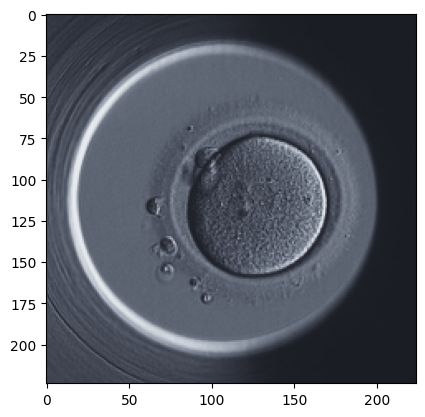

In [36]:
import matplotlib.pyplot as plt

plt.imshow(torch.sigmoid(img_batch)[1, :].to('cpu').detach().numpy().T)


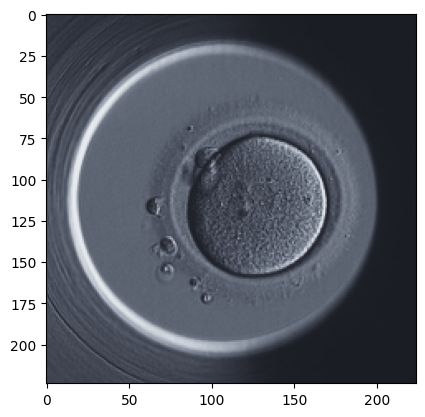

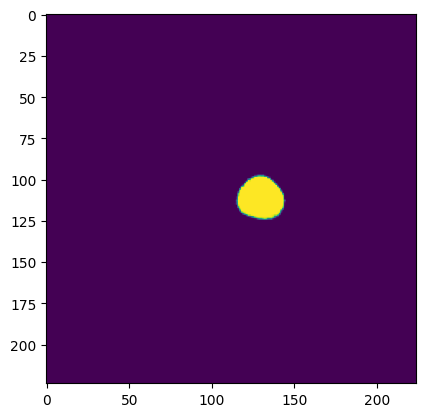

In [35]:
import matplotlib.pyplot as plt

plt.imshow(torch.sigmoid(img_batch)[1, :].to('cpu').detach().numpy().T)
plt.show()
plt.imshow(torch.sigmoid(pred_msk)[1, :].to('cpu').detach().numpy().T)

In [26]:
 validate(model, val_dataloader)

KeyboardInterrupt: 